ta


# Modelització

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn import preprocessing

In [2]:
from sklearn.model_selection import train_test_split,  KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, f1_score, explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [3]:
st_songs = pd.read_csv('standarized_songs.csv', index_col=0)

*** QUEDA FER ESCALAT CORRECTE AMB EL X_TRAIN I Y_TRAIN ***

### Training i test split

In [4]:
X = st_songs.drop(columns = {'popularity'}).iloc[:,2:]
y = st_songs['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model Lineal

In [5]:
# We instantiate a linear regression. 
lr = LinearRegression()

# Now we train it on train data with fit method
lr.fit(X_train,y_train)

# We can predict using the predict method
y_pred = lr.predict(X_train)

weights = lr.coef_
intercept = lr.intercept_
# You can access to some info about the model, like the weights.
print('Coeficients')
for x, y in zip(X.columns, weights[:]):
    print(x, y)
print('Intercept: \n', intercept)

Coeficients
acousticness -0.0011701591771594842
danceability -0.009628141873684007
energy 3.0390401132223248e-05
liveness -0.0041170659768046715
loudness 0.1148014964825194
tempo -0.03253285482097139
valence 0.021183245044743695
duration 0.053317183689312306
taylors_version 0.06466158091263766
performed_live -0.18502941286850594
not_first_release -0.0753331430290373
low_instrumentalness -0.003841242646787902
medium_instrumentalness 0.00523908407488503
spoken_section -0.006001755302658432
Midnights 0.14586801628432708
Lover 0.1680315107778559
reputation 0.1705371467181797
Red (Taylor's Version) 0.0017034561802443636
folklore 0.08516666364968514
Speak Now (Taylor's Version) 0.014500537446409133
Fearless (Taylor's Version) -0.018631386887295154
Live From Clear Channel Stripped 2008 -0.08445852199098415
Speak Now -0.11739389443588334
Fearless -0.15879446227779637
1989 -0.055313125092563684
Taylor Swift -0.06009971936725938
1989 (Taylor's Version) 0.06708897417327908
Red -0.1690851161255201

In [6]:
### Molt important veure quins són els pesos dels coeficients 'album', ja que quan predim no en posarem ###

album_weights = weights[15:]

for x, y in zip(X.columns[15:], album_weights):
    print(x, y)
print('Intercept: \n', intercept)


Lover 0.1680315107778559
reputation 0.1705371467181797
Red (Taylor's Version) 0.0017034561802443636
folklore 0.08516666364968514
Speak Now (Taylor's Version) 0.014500537446409133
Fearless (Taylor's Version) -0.018631386887295154
Live From Clear Channel Stripped 2008 -0.08445852199098415
Speak Now -0.11739389443588334
Fearless -0.15879446227779637
1989 -0.055313125092563684
Taylor Swift -0.06009971936725938
1989 (Taylor's Version) 0.06708897417327908
Red -0.1690851161255201
evermore 0.11145081182484405
Speak Now World Tour Live 0.026265440671935904
reputation Stadium Tour Surprise Song Playlist -0.12683633154946075
Intercept: 
 0.5325544153774887


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Lover'),
  Text(1, 0, 'reputation'),
  Text(2, 0, "Red (Taylor's Version)"),
  Text(3, 0, 'folklore'),
  Text(4, 0, "Speak Now (Taylor's Version)"),
  Text(5, 0, "Fearless (Taylor's Version)"),
  Text(6, 0, 'Live From Clear Channel Stripped 2008'),
  Text(7, 0, 'Speak Now'),
  Text(8, 0, 'Fearless'),
  Text(9, 0, '1989'),
  Text(10, 0, 'Taylor Swift'),
  Text(11, 0, "1989 (Taylor's Version)"),
  Text(12, 0, 'Red'),
  Text(13, 0, 'evermore'),
  Text(14, 0, 'Speak Now World Tour Live'),
  Text(15, 0, 'reputation Stadium Tour Surprise Song Playlist')])

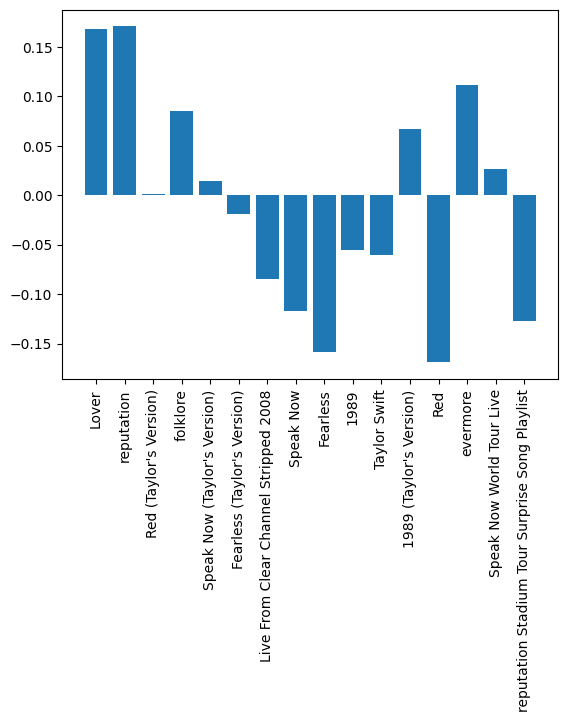

In [7]:
plt.bar(X.columns[15:], album_weights)
plt.xticks(rotation=90)

Veiem que els àlbums més recents (Midnights, evermore, folklore, Lover)...

name
Bad Blood                        0.015164
Long Live (Taylor's Version)     0.064747
ivy                             -0.041057
epiphany                        -0.004204
Bette Davis Eyes - Live/2011     0.022102
                                   ...   
Question...?                    -0.029635
Would've, Could've, Should've   -0.066835
invisible string                 0.066644
Enchanted - Live/2011           -0.014856
Bigger Than The Whole Sky       -0.014967
Name: popularity, Length: 395, dtype: float64


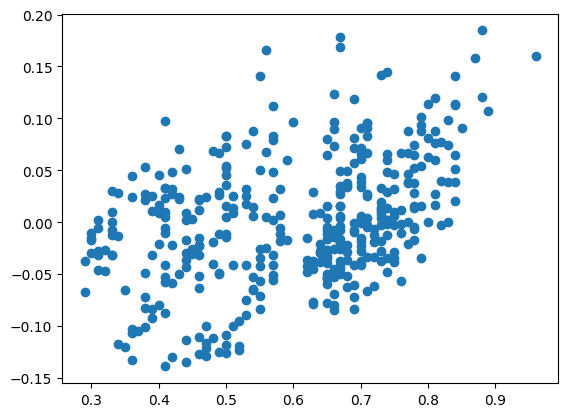

In [8]:
naive_prediction_error = y_train - y_pred
print(naive_prediction_error)

plt.scatter(y_train, naive_prediction_error)
plt.show()

In [9]:
mse = mean_squared_error(y_train, y_pred)
mse

0.00368900331527523

In [10]:
R_squared = r2_score(y_train, y_pred)
norm_mse_sk = 1 - R_squared
norm_mse_sk, R_squared


(0.16310018668466597, 0.836899813315334)

Cross validation

In [11]:
from sklearn.model_selection import LeaveOneOut

N = len(X_train)

lr_cv = LinearRegression()
lr_cv.fit(X_train, y_train)
folds_r2 = cross_val_score(lr_cv, X_train, y_train, cv = 10, scoring='r2')
lr_r2 = np.mean(folds_r2)
print(lr_r2)
print(folds_r2)

0.8125137666037195
[0.80456673 0.81764824 0.84121842 0.78624955 0.7785231  0.88018932
 0.81431524 0.74267037 0.86743801 0.7923187 ]


Veiem que el model lineal de moment explica molta variablitat.

#### Regularització

Ridge:

In [12]:
lambdas = [1e-10,1e-5, 1e-4,1e-4,1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.5, 0.7, 0.8, 1, 2, 10, 100, 200]

In [13]:
ridge_cv = RidgeCV(alphas=lambdas, cv = 10)
ridge_cv.fit(X_train, y_train)
print('Best Lambda:', ridge_cv.alpha_)
print('R2 SCORE: ', ridge_cv.best_score_)

Best Lambda: 0.3
R2 SCORE:  0.8129200380491808


In [14]:
abs(ridge_cv.coef_ - lr.coef_)

array([7.17648525e-04, 1.47052569e-03, 7.61172911e-03, 1.98277171e-04,
       2.11666987e-02, 6.76772078e-05, 3.51706870e-03, 1.16987948e-02,
       1.06975397e-03, 3.58247209e-03, 4.06290643e-04, 1.31983420e-03,
       4.34249906e-03, 9.54772093e-04, 5.33136315e-03, 4.57848891e-03,
       5.87443586e-03, 3.63276821e-04, 2.58612253e-03, 3.07488049e-03,
       7.28132396e-04, 7.43352006e-03, 5.57953535e-03, 4.29577059e-03,
       6.81652811e-04, 4.53776097e-03, 3.09653574e-03, 1.90721709e-03,
       3.28375242e-03, 4.16940928e-03, 3.18361314e-04])

No hi ha hagut massa diferència

#### Lasso

Ridge:

In [15]:
lambdas = [1e-10,1e-5, 1e-4,1e-4,1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.5, 0.7, 0.8, 1, 2, 10, 100, 200]

In [16]:
lasso_cv = LassoCV(alphas=lambdas, cv = 10)
lasso_cv.fit(X_train, y_train)
print('Best Lambda:', lasso_cv.alpha_)
lasso_r2 = r2_score(y_train, lasso_cv.predict(X_train))
print('R2 SCORE: ', lasso_r2)

Best Lambda: 0.0001
R2 SCORE:  0.8363026430069846


C:\Users\mique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019276694235455194, tolerance: 0.0008015717183098591
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021089332528458016, tolerance: 0.000792597915492958
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:664: Con

In [17]:
abs(lasso_cv.coef_ - lr.coef_)

array([0.00119989, 0.00602704, 0.00439541, 0.00038099, 0.02153322,
       0.0031531 , 0.00798876, 0.02182921, 0.04619689, 0.02529118,
       0.0010148 , 0.00384124, 0.00523908, 0.00600176, 0.03449899,
       0.03721842, 0.03581639, 0.00170346, 0.03900347, 0.00053084,
       0.00010933, 0.08445852, 0.04887576, 0.04628065, 0.04357826,
       0.04948818, 0.00732736, 0.04427188, 0.03912496, 0.06561631,
       0.07218951])

No hi ha hagut massa diferència

## Random forest i Decision tree

In [18]:
rf = RandomForestRegressor(oob_score=True)
model_rf = rf.fit(X_train, y_train)

y_pred_tree = model_rf.predict(X_train)

print(r2_score(y_train, y_pred_tree))
print(mean_squared_error(y_train, y_pred_tree))
print(1 - r2_score(y_train, y_pred_tree))


print('OOB accuracy=', model_rf.oob_score_)

0.9601248369943631
0.0009018972419040411
0.03987516300563687
OOB accuracy= 0.7891135516949395


MOLT baix error -> Però segurament és degut a overfitting (salt entre r2_score i OOB score)
La precisió pel OOB set és bastant bona, però.

Podriem afegir GridSearch (tant al DecisionTree com al RandomForest) !

### GridSearch per Decision Tree

Anem a veure si un Decision Tree SOL és capaç de fer una bona regressió.

10 folds CV

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Define the parameter grid for grid search
param_grid = {
    'max_depth': [8, 9, 10, 11, 12],  # values around 10
    'min_samples_split': [2, 3, 4, 5, 6],  # values around 4
    'min_samples_leaf': [5, 6, 7, 8, 9],  # values around 7
    'max_features': ['sqrt', 'log2', None]  # including None as it was the best in the previous run
}

scoring = {
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Create a decision tree regressor
dt = DecisionTreeRegressor(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring=scoring, refit='r2', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)  

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new decision tree with the best parameters
best_dt = DecisionTreeRegressor(random_state=42,**best_params)

# Fit the new decision tree to the training data
best_dt.fit(X_train, y_train)

# Predict using the new decision tree
y_pred_best_decision_tree = best_dt.predict(X_test)

In [20]:
print(r2_score(y_test, y_pred_best_decision_tree))

0.7600182457508693


In [21]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
    'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'mean_test_r2'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_r2
63,8,5,7,None,-0.054189,-0.004873,0.7803
64,8,6,7,None,-0.054189,-0.004873,0.7803
60,8,2,7,None,-0.054189,-0.004873,0.7803
61,8,3,7,None,-0.054189,-0.004873,0.7803
62,8,4,7,None,-0.054189,-0.004873,0.7803


5 folds CV

In [22]:

# Create a decision tree regressor
dt = DecisionTreeRegressor(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring=scoring, refit='r2', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)  

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new decision tree with the best parameters
best_dt = DecisionTreeRegressor(random_state=42,**best_params)

# Fit the new decision tree to the training data
best_dt.fit(X_train, y_train)

# Predict using the new decision tree
y_pred_best_dt = best_dt.predict(X_test)

In [23]:
print(r2_score(y_test, y_pred_best_dt))

0.7698973387369481


In [24]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
    'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'mean_test_r2'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_r2
286,11,3,7,None,-0.051778,-0.004639,0.792127
287,11,4,7,None,-0.051778,-0.004639,0.792127
288,11,5,7,None,-0.051778,-0.004639,0.792127
289,11,6,7,None,-0.051778,-0.004639,0.792127
285,11,2,7,None,-0.051778,-0.004639,0.792127


Un bon decision tree! Quasi el 80% de la variància explicada per ambdós nivell de folds. És bàsicament tant bo com el RF sense Grid Search.

Coses a veure: hi ha poc overfitting perquè el r2 mitjà de la CV és quasi igual al de r2 de generalització?

In [25]:
# best parameters

# param_grid = {
#     'max_depth': [9],
#     'min_samples_split': [2, 3, 4, 5, 6],
#     'min_samples_leaf': [7],
#     'max_features': [None]
# }

### GridSearch per Random Forest

In [41]:
param_grid = {
    'n_estimators': [200], # 200 is the best, tried for 10 and 100 too
    'max_depth': [8],  # values around 10. 8 was the best
    'min_samples_split': [2, 3, 4, 5, 6],  # values around 4
    'min_samples_leaf': [5],  # values around 7. 5 was best
    'max_features': ['sqrt', 'log2', None]  # including None as it was the best in the previous run
}

scoring = {
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Create a decision tree regressor
rf = RandomForestRegressor(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring=scoring, refit='r2', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)  

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new decision tree with the best parameters
best_rf = RandomForestRegressor(oob_score=True,random_state=42,**best_params)

# Fit the new decision tree to the training data
best_rf.fit(X_train, y_train)

# Predict using the new decision tree
y_pred_best_rf = best_rf.predict(X_test)

In [42]:
print('OOB accuracy=', best_rf.oob_score_)

OOB accuracy= 0.8029845231783246


In [43]:
print(r2_score(y_test, y_pred_best_rf))

0.7786552379519365


In [32]:
best_rf.n_estimators

200

In [34]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
    'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'mean_test_r2'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_r2
158,8,4,5,None,-0.05356,-0.004688,0.790078
161,8,5,5,None,-0.05356,-0.004688,0.790078
155,8,3,5,None,-0.05356,-0.004688,0.790078
164,8,6,5,None,-0.05356,-0.004688,0.790078
152,8,2,5,None,-0.05356,-0.004688,0.790078


## SVM

In [44]:
from sklearn.svm import SVR